<a href="https://colab.research.google.com/github/chahatpatel2003/CSCI-167/blob/main/notebook_10_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

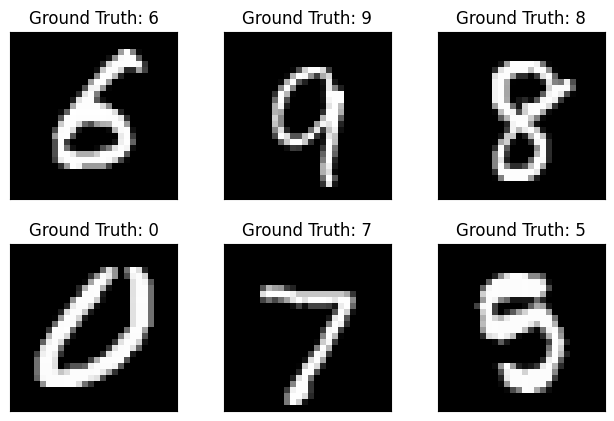


Test set: Avg. loss: 2.5578, Accuracy: 1120/10000 (11%)

Train Epoch: 1 [0/60000]	Loss: 2.689610
Train Epoch: 1 [640/60000]	Loss: 2.274246
Train Epoch: 1 [1280/60000]	Loss: 2.103950
Train Epoch: 1 [1920/60000]	Loss: 1.973590
Train Epoch: 1 [2560/60000]	Loss: 1.981778
Train Epoch: 1 [3200/60000]	Loss: 1.488175
Train Epoch: 1 [3840/60000]	Loss: 1.298521
Train Epoch: 1 [4480/60000]	Loss: 1.415692
Train Epoch: 1 [5120/60000]	Loss: 0.871649
Train Epoch: 1 [5760/60000]	Loss: 1.098949
Train Epoch: 1 [6400/60000]	Loss: 0.916908
Train Epoch: 1 [7040/60000]	Loss: 0.712365
Train Epoch: 1 [7680/60000]	Loss: 1.014723
Train Epoch: 1 [8320/60000]	Loss: 0.543985
Train Epoch: 1 [8960/60000]	Loss: 0.495010
Train Epoch: 1 [9600/60000]	Loss: 0.653090
Train Epoch: 1 [10240/60000]	Loss: 0.875002
Train Epoch: 1 [10880/60000]	Loss: 0.544825
Train Epoch: 1 [11520/60000]	Loss: 0.548545
Train Epoch: 1 [12160/60000]	Loss: 0.569504
Train Epoch: 1 [12800/60000]	Loss: 0.545606
Train Epoch: 1 [13440/60000]	Loss: 0.4

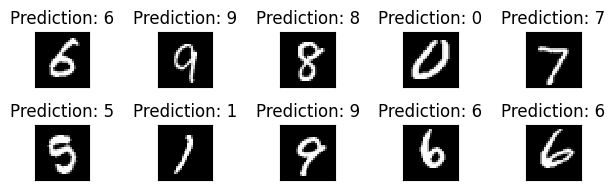

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

batch_size_train = 64
batch_size_test = 1000
myDir = "./data"

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        myDir, train=True, download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])
    ),
    batch_size=batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        myDir, train=False, download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])
    ),
    batch_size=batch_size_test, shuffle=True
)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Ground Truth: {example_targets[i].item()}")
    plt.xticks([]); plt.yticks([])
plt.show()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.drop2d = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(20 * 4 * 4, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.drop2d(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.flatten(1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

import math
def weights_init(layer_in):
    if isinstance(layer_in, nn.Linear):
        nn.init.kaiming_uniform_(layer_in.weight)
        if layer_in.bias is not None:
            layer_in.bias.data.zero_()
    if isinstance(layer_in, nn.Conv2d):
        nn.init.kaiming_uniform_(layer_in.weight, a=math.sqrt(5))
        if layer_in.bias is not None:
            layer_in.bias.data.zero_()

model = Net()
model.apply(weights_init)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]\tLoss: {loss.item():.6f}")

def test():
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = 100.0 * correct / len(test_loader.dataset)
    print(f"\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.0f}%)\n")

test()
for epoch in range(1, 4):
    train(epoch)
    test()

output = model(example_data)
fig = plt.figure()
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pred = output.argmax(dim=1, keepdim=True)[i].item()
    plt.title(f"Prediction: {pred}")
    plt.xticks([]); plt.yticks([])
plt.show()
